# ioniq

### Nanopore signal analysis framework

In [54]:
# Import libraries and modules

import ioniq.core as ct
from ioniq.io import EDHReader, OPTReader
import ioniq.datatypes as dt
from ioniq.utils import Trimmer, Filter
from ioniq.utils import extract_features

import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import inspect
from scipy.signal import find_peaks

! pip install pyqt6



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [43]:
# from importlib import reload
# import ioniq.io
# reload(ioniq.io)
# from ioniq.io import OPTReader
# reload(ioniq.parsers)
# from ioniq.parsers import AutoSquareParser
# reload(ioniq.utils)


<module 'ioniq.utils' from '/Users/dinaraboyko/grad_school/cloned_repo/ioniq/src/ioniq/utils.py'>

## Upload files

#### in this demo we focus on the Axopatch output XML, _volt.opt files with timestamps, voltages, and corresponding opt files with the current data

### Step 1: 
Provide the path to the data folder

In [44]:

datafiles=glob.glob('/Users/dinaraboyko/grad_school/cloned_repo/data/**/*[0-9].opt') # Replace the path here
print(f"Found {len(datafiles)} files \n")
print(*datafiles , sep='\n')

Found 9 files 

/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_933--222051.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_933--221228.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_220--214932.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_933--220626.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_000--214219.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_933--220403.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/TOKW/B082224SR_250kHz__003.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/TOKW/B082224SR_250kHz__016.opt
/Users/dinaraboyko/grad_school/cloned_repo/data/TOKW/B090624SR_100kHz__000.opt


# Observe current and voltage. Raw data

### Run the following cell to plot the current against the time with an aligned voltage

The plots will be saved in the folder "snapshots".

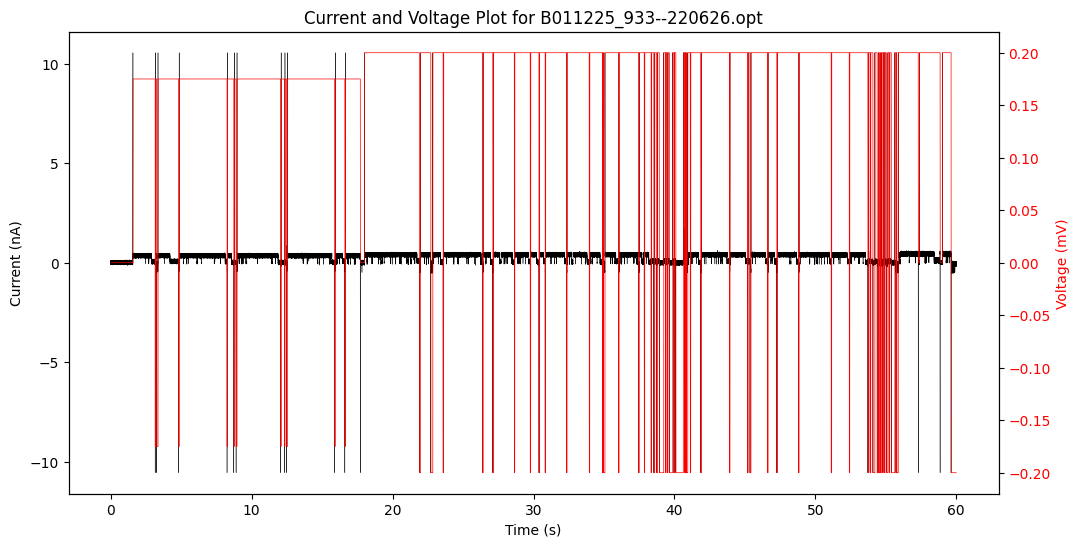

In [45]:
for file in datafiles[3:4]: # adjust number of infiles to be processed
    metadata, current, voltage = OPTReader(file, voltage_compress=True, downsample=5)
    sampling_frequency = metadata['Sampling frequency (SR)']
    time = np.linspace(0, len(current) / sampling_frequency, num=len(current))
    voltage_ = np.zeros(len(current))
    for (start, end), value in voltage:
        voltage_[start:end] = value
        
    # adjust plot size here if needed 
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    
    ax1.plot(time, current, lw=0.3, c='k', label='Current')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Current (nA)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    
    ax2 = ax1.twinx()
    ax2.plot(time, voltage_, lw=0.5, c='r', label='Voltage')
    ax2.set_ylabel('Voltage (mV)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    file_name = metadata["HeaderFile"].split("/")[-1]
    plt.title(f"Current and Voltage Plot for {file_name}")

    
    fig.savefig(os.path.join("snapshots", os.path.splitext(os.path.split(metadata["HeaderFile"])[-1])[0]+".png"), bbox_inches="tight")
   


# Select files

### Step 2.

##### Now when you have plotted the current, take a look at the traces and manually pick the .png files you want to proceed with. 

*Create a folder "selected_files" and copy selected plots to it.*


### Step 3.

Run the following cell to convert the selected plot's name into a file name.


# Observe preprocessed files

## Extract metadata, current and voltage from the input file with the parameters:

*voltage_compress* is a boolean parameter.
* True voltage data is compressed and represented in a summarized format (list of start and end points for each voltage step)
* False voltage is a full array

*downsample* is the factor by which the data is downsampled. 
* downsample=1: all data points are preserved.
* downsample=10: every 10th data point is retained, reducing data size.

*prefilter*: apply the following filters of on the data: 

* Low-pass filters: Remove high-frequency noise.
* High-pass filters: Remove baseline drifts or low-frequency artifacts.
* Band-pass filters: Retain a specific frequency range for analysis.
* Band-stop filters:

  define the method:
  filter_method:

  * butter, bessel
   


In [46]:
# Initialize Filter

cutoff_frequency = 25000
filter_type = "lowpass"
filter_method = "bessel"
order = 2
bidirectional = True
sampling_frequency = 250000
downsample = 5

filt = Filter(
    cutoff_frequency=cutoff_frequency,
    filter_type='lowpass',
    filter_method = filter_method,
    bidirectional=bidirectional,
    sampling_frequency=sampling_frequency
)
trimmer=Trimmer(samples_to_remove=100)

In [56]:
# Apply filters
sfm = dt.SessionFileManager()
sfm.clear_children()

for datafile in datafiles[1:2]:
    print(datafile)
    metadata, current, voltage = OPTReader(datafile, voltage_compress=True, downsample=5, prefilter=filt)
    metadata['eff_sampling_freq'] = sampling_frequency / downsample

    trace_file = dt.TraceFile(
        current=current,
        voltage=voltage,
        parent=sfm,
        metadata=metadata,
        unique_features={
            "sampling_freq": metadata["eff_sampling_freq"],
            "eff_sampling_freq": metadata["eff_sampling_freq"]
        }
    )

    trimmer(trace_file)

    for segment in trace_file.traverse_to_rank("vstepgap"):
        event_parser = AutoSquareParser(segment, voltage_range=(0.149, 0.251), threshold_baseline=0.7)
        segment.parse(parser=event_parser, newrank="event")
        df = extract_features(segment, bottom_rank='event',
             extractions=['mean', 'frac', 'duration', 'baseline', 'current', 'wrap', 'start'],
             add_ons={"sample_type": "MBP_D10"},
             lambdas={"Voltage": lambda segment: int(1000 * segment.get_feature("voltage")),
                      "start_time": lambda seg: segment.start / segment.get_feature("eff_sampling_freq")})
        

/Users/dinaraboyko/grad_school/cloned_repo/data/011225/B011225_933--221228.opt


In [57]:
df

,mean,frac,duration,baseline,current,wrap,start,sample_type,Voltage,start_time
0,0.013229,0.898825,0.00008,0.164690,"[-0.00685019106557267, -0.006327201245433413, ...","[-0.11350983395720884, -0.12384583853533063, -...",413984,MBP_D10,0,424.8853
1,0.073505,0.437822,0.00002,0.094253,[0.0735048273884512],"[-0.08039909804527307, -0.08556964332254653, -...",413997,MBP_D10,0,424.8853
2,0.067120,0.486653,0.00002,0.170180,[0.06712009532873105],"[-0.03696888709382738, -0.039340884160977675, ...",414017,MBP_D10,0,424.8853
3,0.030403,0.767475,0.00002,0.316938,[0.03040265108379741],"[0.09718515150479165, 0.13570941722126348, 0.1...",414104,MBP_D10,0,424.8853
4,0.060722,0.535590,0.00006,0.095768,"[0.04937268508284278, 0.06928741168774114, 0.0...","[0.1825358411700571, 0.2011955690745462, 0.165...",414340,MBP_D10,0,424.8853
...,...,...,...,...,...,...,...,...,...,...
8222,0.007672,0.941323,0.00008,0.144430,"[-0.04301810967971634, -0.0027755821580170764,...","[-0.0691387736969381, -0.1169046856240746, -0....",2755361,MBP_D10,0,424.8853
8223,0.020942,0.839829,0.00002,0.120895,[0.020942397173209244],"[-0.0809210896678049, -0.06709659435798013, -0...",2755377,MBP_D10,0,424.8853
8224,0.071618,0.452250,0.00006,0.181957,"[0.07628349610754394, 0.08014454631619795, 0.0...","[0.05626520948195795, 0.020942397173209244, 0....",2755426,MBP_D10,0,424.8853
8225,0.032324,0.752780,0.00004,0.286082,"[0.0142436662949632, 0.05040447741806527]","[0.15298412291769037, 0.13340675800026366, 0.1...",2755480,MBP_D10,0,424.8853


## Conductance plot

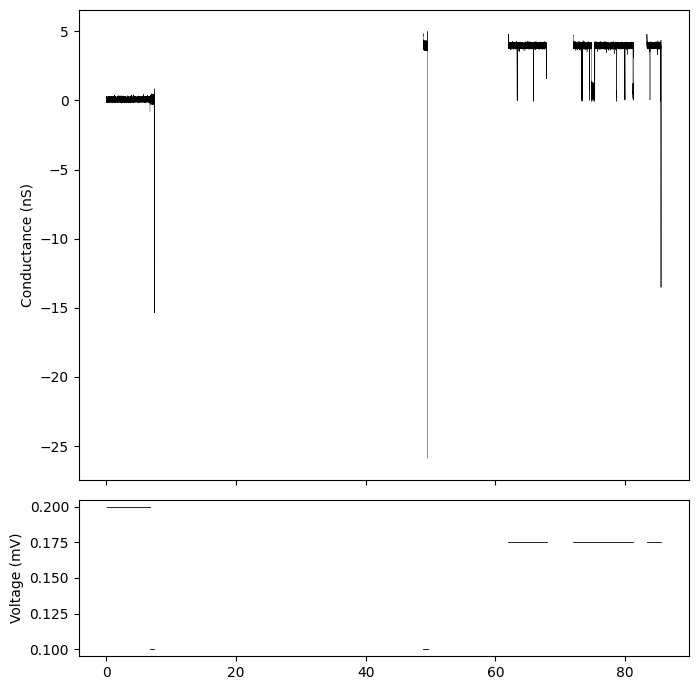

In [20]:
 # Conductance in nS
%matplotlib inline
for i, tf in enumerate(sfm.children):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, num=i+1, 
                                   gridspec_kw={'height_ratios': [3, 1]}, figsize=(7, 7))
    for child in tf.traverse_to_rank("vstepgap"):
        voltage = child.get_feature("voltage")
        if voltage > 0:  
            conductance = child.current  / voltage 
            ax0.plot(child.time, conductance, lw=0.3, c='k') 
            ax1.plot([child.time[0], child.time[-1]], [voltage] * 2, lw=0.6, c='k')
    #file_name = tf.get_feature("metadata")["HeaderFile"].split("/")[-1]
    #plt.title(f"Conductance for {file_name}")
    ax0.set_ylabel("Conductance (nS)")
    ax1.set_ylabel("Voltage (mV)")
plt.tight_layout()
plt.show()

## Curent and voltage steps

In [39]:
%matplotlib qt
for i, tf in enumerate(sfm.children):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2=ax1.twinx()
    for child in tf.traverse_to_rank("vstep"):
        ax1.plot(child.time, child.current, lw=0.3, label='Current')
        ax2.plot([child.time[0],child.time[-1]], [child.unique_features['voltage']]*2, lw=0.5, c='r')
        #file_name = tf.get_feature("metadata")["HeaderFile"].split("/")[-1]
        #plt.title(f"Current and Voltage Plot for {file_name}")
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Current (nA)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')
    ax2.set_ylabel('Voltage (mV)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.tight_layout()
    plt.show()


# Start event parser

In [54]:
import numpy.ma as ma
from ioniq.parsers import lambda_event_parser
plt.close('all')
color_map={80.0:"tab:grey",60:"tab:blue",150:"tab:green",90:"tab:orange",120.0:"tab:red",100:"tab:purple"}
def parse(tf,starts=None,ends=None,voltage_range=(0.149,0.251),threshold=0.7):
    if starts is None:
        starts=[tf.time[0]]
    if ends is None:
        ends=[tf.time[-1]]
    
    steps=set()
    # print(len(tf.traverse_to_rank("vstepgap")))
    for step in tf.traverse_to_rank("vstepgap"):
        for start,end in zip(starts,ends):
            # print(step.get_feature('voltage'))
            if start<step.time[0] and step.time[-1]<end and voltage_range[0]<=step.get_feature("voltage")<=voltage_range[1]:
                steps.add(step)
    if len(steps)==0:
        return
    steps=list(steps)
    # plt.figure()
    ti=0
    results=[]
    for step in steps:
        # plt.plot(step.t,step.current,c='k',lw=0.4)
        mask=np.where(step.current>100e-3,1,0)
        masked_current=ma.masked_array(step.current,mask)
        
        hist,edges=np.histogram(masked_current,bins=150,range=(50e-3,900e-3))
        centers=edges[:-1]+(edges[1]-edges[0])*0.5
        I0guess=centers[np.argmax(hist)]

        Ithresh=I0guess*threshold

        if I0guess<150e-3:
            continue
        eventmask=np.where(step.current<Ithresh,1,0)
        lambda_parser=lambda_event_parser(threshold=Ithresh,rules=[lambda event:0<event.mean<I0guess*0.6,lambda event:event.duration>4])
        
        events=lambda_parser.parse(step.current)
        if len(events)==0:
            continue
        for i in range(len(events)):
            
            if i==len(events)-1:
                bstart=events[i].start+events[i].duration
                print("bstart", bstart)
                bend=step.current.shape[0]
                
            else:
                bstart=events[i].start+events[i].duration
                bend=events[i+1].start
                # baseline=step.current[events[i].start+events[i].duration:events[i+1].start]
            baseline=step.current[bstart:bend]
            events[i].I0=np.median(baseline,axis=-1)
            if events[i].I0<0.5e-10:
                print(baseline*1e9,bstart,bend)
                # event.I0=np.median(step.current[])
        # print(len(events))
        if events[-1].start+events[-1].duration==step.current.shape[0]:
            events.pop(-1)     
        if len(events)==0:
            continue  
        if events[0].start==0:
            events.pop(0)   
        for event in events:
            event.parent=step
            wstart=max(event.start-50,0)
            wend=min(event.start+event.duration+50,step.current.shape[0])
            # print(wstart,wend)
            event.wrap=step.current[wstart:wend]   
            
        for event in events:
            event.duration=1/250000*event.current.shape[0]
            event.voltage=step.get_feature("voltage")
            # if np.log10(event.duration)>-4:
            #     continue
            t=np.arange(event.current.shape[0])/250000+ti
            # plt.plot(t,event.current,lw=0.4)
            # # plt.plot(t,[I0guess]*t.shape[0])
            ti+=event.duration+0.005
        
        # color=color_map[round(float(step.get_feature("voltage")),3)]
        results+=events

    plt.figure()
    #plt.title(tf.metadata["HeaderFile"])
    plt.plot(tf.time[::],tf.current[::],lw=0.5,c='k')
    for event in results:
        # print(event.parent.start)
        # print(event.start)
        t=np.arange(event.current.shape[0])/50000+event.start/50000+event.parent.time[0]
        
        plt.plot(t,event.current,lw=1,c='r')
    
        # plt.scatter([I0guess]*len(events),[np.log10(event.duration) for event in events],c=color,s=4)
        # print([np.mean([np.log10(event.duration) for event in events],axis=-1)])
        # plt.scatter([I0guess],[np.median([np.log10(event.duration) for event in events],axis=-1)],marker="*",s=10,c='r')
        # plt.hist2d([I0guess]*len(events),[np.log10(event.duration) for event in events],range=[ [1e-10,5e-10],[-3.5,1]],bins=(40,20),norm='log')
        # plt.scatter([np.log10(event.duration) for event in events],[1-event.mean/event.I0 for event in events],c=color,s=4)
        
    # plt.xlim(0.6,1)
    # plt.ylim(-4,1)
        # plt.plot(centers,hist)

        
    return results
dfs={}
for tf in sfm.children: 
    events=parse(tf)
    print(events)
    #key=tf.metadata["HeaderFile"]
    key=str(datafiles[10:11])
    print(key)
    # rootfolder=os.path.split(key)[0]
    rootfolder=key
    dfs[key]=pd.DataFrame(columns=['mean','frac','dwell','baseline','Voltage','current','wrap','rootfolder'])
    print(dfs[key])
    for event in events:
        dfdict={"mean":event.mean,
                "frac":1-event.mean/event.I0,
                "dwell":event.duration,
                "baseline":event.I0,
                "Voltage":int(round(float(event.voltage),3)),
            "current":event.current,
            "wrap":event.wrap,
            "rootfolder":rootfolder}
        
        dfs[key].loc[len(dfs[key])]=dfdict

bstart 461777
bstart 105277
bstart 195090
[{
    "mean" : 0.08197212489334889,
    "std" : 0.040305544578573785,
    "min" : -0.011239642045758232,
    "max" : 0.3959892869332884,
    "start" : 65086,
    "end" : null,
    "duration" : 0.012208,
    "name" : "Segment"
}, {
    "mean" : 0.09145031279251847,
    "std" : 0.038825888336517,
    "min" : 0.0012645416369212298,
    "max" : 0.41292501159086165,
    "start" : 124638,
    "end" : null,
    "duration" : 0.0030559999999999997,
    "name" : "Segment"
}, {
    "mean" : 0.14833978831250774,
    "std" : 0.03360284321144836,
    "min" : -0.014162541757813542,
    "max" : 0.4598895017567105,
    "start" : 137990,
    "end" : null,
    "duration" : 0.098428,
    "name" : "Segment"
}, {
    "mean" : 0.09340388651665417,
    "std" : 0.04094157643857141,
    "min" : 0.007891129790016192,
    "max" : 0.22544635219238554,
    "start" : 164524,
    "end" : null,
    "duration" : 0.00376,
    "name" : "Segment"
}, {
    "mean" : 0.0695927822776

In [25]:
_dff=list(dfs.values())[0].iloc[128:135]
plt.figure()

toffset=0
gap=0.0007
sampling_freq=50000
for idx, row in _dff.iterrows():
    t=np.arange(row.wrap.shape[0])/sampling_freq+toffset
    plt.plot(t,row.wrap,lw=0.5,c='k')

    toffset=t[-1]+gap

IndexError: list index out of range

# Features. Combined by experiment

In [24]:
%matplotlib qt
import matplotlib as mpl
plt.close('all')
hueorder=[80,90,120,150]
hueorder=list(map(str,hueorder))
mpl.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.family"]=["Arial"]
plt.rcParams["ps.useafm"] = True
plt.rcParams["figure.dpi"]=150


masterdf=pd.concat([_df for _df in dfs.values()])
for groupname,df in masterdf.groupby("rootfolder"):
    # sns.set_theme("white")
    
    sns.set_style("ticks")
    df["logdwell"]=np.log10(df["dwell"])
    df["fracpct"]=np.multiply(df["frac"],100)
    df["voltagestr"]=df["Voltage"].astype(str)
    print(df["voltagestr"].unique())
    plt.figure(figsize=(3.5,3.5))
    palette=sns.color_palette("tab10", 4)
    ax=sns.scatterplot(df,x="logdwell",y='fracpct',hue='voltagestr',palette=palette,hue_order=hueorder,s=4)
    # ax=sns.scatterplot(df,x="baseline",y='fracpct',hue='voltagestr',palette=palette,hue_order=hueorder,s=6)
    handles,labels=ax.get_legend_handles_labels()
    
    sns.move_legend(ax,loc="lower right",title="Voltage",handles=handles,labels=[str(x)+" mV" if x in df["voltagestr"].unique() else "_" for x in labels ],handletextpad=0)
    # plt.ylim(70,100)
    # plt.xlim(-3.5,1)
    plt.ylabel("Blockade (%)")
    plt.xlabel("Log10 (dwell time [s])")
    # plt.savefig(f"{key}_scatter.pdf")
    
    sns.set_theme(style='white', rc={"axes.facecolor": (0, 0, 0, 0)})
    binrange=[-3.5,1]
    binwidth=0.15
    bin_count=int((binrange[1]-binrange[0])/binwidth)
    # g = sns.FacetGrid(_df, row="Voltage (V)",row_order=hueorder, hue="Voltage (V)", hue_order=hueorder, aspect=8, height=.5,sharey=False,sharex=True, palette='rainbow',xlim=binrange)
    # g.map(sns.histplot, "frac",
    #   binwidth=binwidth,binrange=binrange, clip_on=True,
    #   fill=True, alpha=1, linewidth=0.45,common_norm=True,log_scale=(False,True))
    # plt.figure()
    
    g = sns.FacetGrid(df, row="voltagestr",row_order=hueorder, hue="voltagestr", hue_order=hueorder, 
                      aspect=10, height=.35,sharey=False,sharex=True, palette=palette,xlim=binrange)
    g.map(sns.histplot, "logdwell",
      binwidth=binwidth,binrange=binrange, clip_on=True,
      fill=True, alpha=1, linewidth=0.5,common_norm=True,hue_norm=(150,225))
    g.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.84, .28, label+"V", fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    g.map(label,'logdwell')
    g.figure.subplots_adjust(hspace=-0.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="",xlabel="")
    g.despine( left=True)
    # g.figure.savefig(f"{key}_dwell_hist.pdf")
    # print(g.axes.shape)
    # g.axes[3,0].tick_params(axis='x',reset=True,top=False)
    # g.refline(y=0.8, linewidth=0.4, linestyle="-", color=None, clip_on=False)
    

ValueError: No objects to concatenate

In [ ]:
dfs[key]=pd.DataFrame(columns=['mean','frac','dwell','baseline','Voltage','current','wrap','start','rootfolder','sample_type'])
    print(dfs[key])
    for event in events:
        dfdict={"mean":event.mean,
                "frac":1-event.mean/event.I0,
                "dwell":event.duration,
                "start":event.time[0],
                "baseline":event.I0,
                "Voltage":int(1000*round(float(event.voltage),3)),
            "current":event.current,
            "wrap":event.wrap,
            "rootfolder":rootfolder,
             "sample_type":sample_type}
        
        dfs[key].loc[len(dfs[key])]=dfdict
    

In [30]:
extract_features(tf, bottom_rank='event', 
                 extractions=['mean','frac','duration','baseline','current','wrap','start'],
                 add_ons={"sample_type":"MBP_D10"},
                 lambdas={"Voltage": lambda seg:int(1000*seg.get_feature("voltage")),
                          "start_time":lambda seg:seg.start/seg.get_feature("eff_sampling_freq")}
def extract_features(seg,bottom_rank,extractions:list[str],add_ons:dict={},lambdas={}):
    headers=extractions+list(add_ons.keys())+list(lambdas.keys())
    df=pd.DataFrame(columns=headers)
    for bottom_seg in seg.traverse_to_rank(bottom_rank):
        row_dict={}
        for feature in extractions:
            row_dict[feature] = bottom_seg.get_feature(feature)
        for feature,value in add_ons.items():
            row_dict[feature] = value
        for feature,lambda_func in lambdas.items():
            row_dict[feature] = lambda_func(bottom_seg)
        df.loc[len(df)]=row_dict
    return df

SyntaxError: unterminated string literal (detected at line 3) (433247276.py, line 3)

In [ ]:
"